In [1]:
%load_ext autoreload
%autoreload 2
from steinhardt.models import CrossEntropyClassification
from steinhardt.data import train_val_test_split, get_descriptor_and_labels
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, RichProgressBar
import torch
import numpy as np

In [3]:
desc_type = "steinhardt"
use_mda = True
numb_train_samples = 8_000
struct_types=['hda','lda']

In [4]:
train_structs, val_structs, test_structs = train_val_test_split(struct_types=struct_types,mda=use_mda,num_files=None)

In [5]:
len(train_structs), len(val_structs), len(test_structs)

(1285, 20, 1245)

In [6]:
if desc_type == 'soap':
    n_max = 10
    l_max = 4
    cutoff = 5
    sigma = 0.50
    train_x, train_y, label_mapping = get_descriptor_and_labels(
        train_structs, descriptor=desc_type, num_samples_per_type=numb_train_samples,n_max=n_max,l_max=l_max,cutoff=cutoff,sigma=sigma
    )
    val_x, val_y, val_permutation = get_descriptor_and_labels(
        val_structs, descriptor=desc_type, num_samples_per_type=2_500,n_max=n_max,l_max=l_max,cutoff=cutoff,sigma=sigma
    )
else:
    train_x, train_y, label_mapping = get_descriptor_and_labels(train_structs, descriptor=desc_type, num_samples_per_type=numb_train_samples)
    val_x, val_y, _ = get_descriptor_and_labels(val_structs, descriptor=desc_type, num_samples_per_type=2_500)
    test_x, test_y, _ = get_descriptor_and_labels(test_structs, descriptor=desc_type, num_samples_per_type=2_500)

num_labels = train_y.shape[1]

In [7]:
label_mapping

{'hda': 0, 'lda': 1, 'mda': 2}

In [8]:
from sklearn import preprocessing

# fit to training data
scaler = preprocessing.StandardScaler().fit(train_x)
scaled_train_x = torch.FloatTensor(scaler.transform(train_x))
scaled_val_x = torch.FloatTensor(scaler.transform(val_x))

In [9]:
if desc_type=='steinhardt':
    desc_to_keep = range(0,30)

    updated_train_x = scaled_train_x[:,desc_to_keep]
    updated_val_x = scaled_val_x[:,desc_to_keep]
else:
    updated_train_x = scaled_train_x
    updated_val_x = scaled_val_x

In [10]:
train_dataset = TensorDataset(updated_train_x,train_y)
val_dataset = TensorDataset(updated_val_x,val_y)

train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10000, shuffle=False)

In [11]:
# define the neural network architecture
input_size = updated_train_x.shape[1]
hidden_layers = [20,20,20]
patience = 10

neural_net = CrossEntropyClassification(
    input_size,
    *hidden_layers,
    num_labels,
)

In [12]:
trainer = Trainer(
        accelerator="auto",
        max_epochs=200,
        callbacks=[
            RichProgressBar(),
            EarlyStopping(monitor="validation_loss", patience=patience),
        ],
    )
trainer.fit(neural_net, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/zoefaurebeaulieu/miniconda3/envs/steinhardt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ activation │ ReLU       │      0 │
│ 1 │ layers     │ ModuleList │  1.5 K │
└───┴────────────┴────────────┴────────┘

Trainable params: 1.5 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 K                                                                                                
Total estimated model params size (MB): 0

Output()

/Users/zoefaurebeaulieu/miniconda3/envs/steinhardt/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may 
be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus 
on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/Users/zoefaurebeaulieu/miniconda3/envs/steinhardt/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

In [13]:
# generate test set predictions
from steinhardt.data import predict_test_set_classes
from sklearn.metrics import balanced_accuracy_score

if desc_type == 'soap':
    pred_classes, test_classes, confidences = predict_test_set_classes(test_structs,model=neural_net, scaler=scaler,write_to_file=False,descriptor=desc_type,cutoff=cutoff,sigma=sigma,n_max=n_max,l_max=l_max)
else:
    pred_classes, test_classes, confidences = predict_test_set_classes(test_structs,model=neural_net, scaler=scaler,write_to_file=False,descriptor=desc_type,desc_to_keep=desc_to_keep)

av_accuracy = balanced_accuracy_score(test_classes, pred_classes)

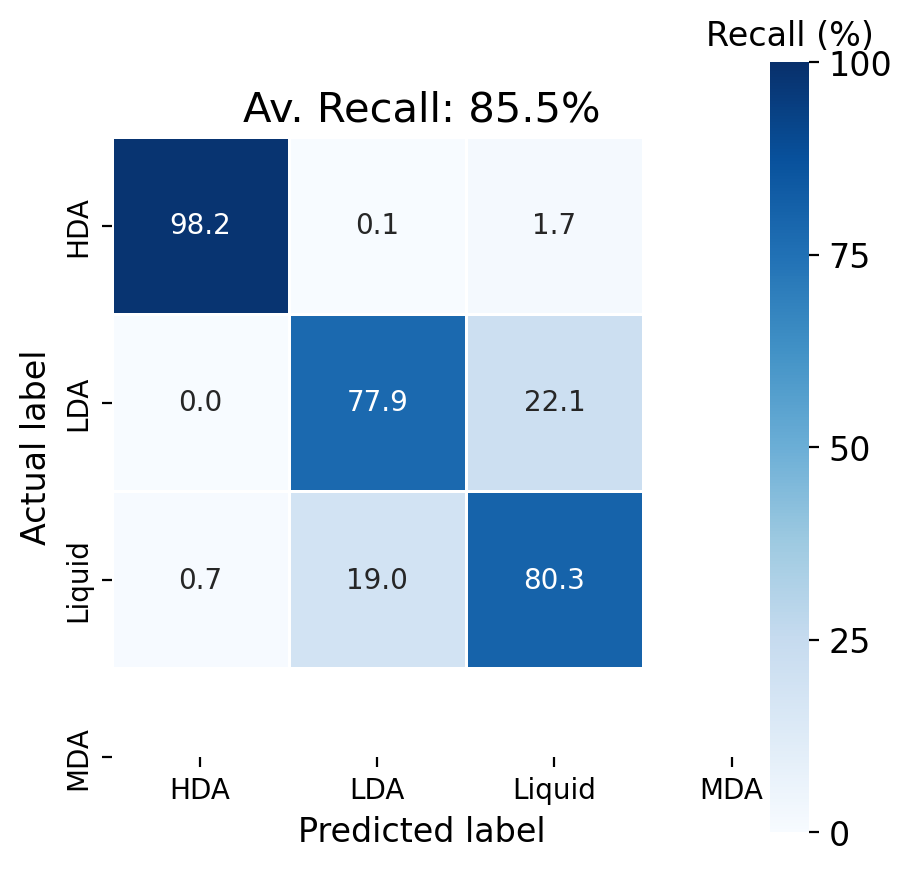

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')

fig, ax = plt.subplots(figsize=(5,5))

cm = confusion_matrix(test_classes, pred_classes, normalize='true')
sns.heatmap(cm*100, annot=True, ax=ax, cmap='Blues', fmt='.1f',linewidths=0.5,square=True, vmin=0, vmax=100)

if use_mda == True:
    plot_labels = ['HDA','LDA','Liquid','MDA']
    ax.set_xticks([0.5, 1.5, 2.5, 3.5],plot_labels)
    ax.set_yticks([0.5, 1.5, 2.5, 3.5],plot_labels)
else:
    plot_labels = ['HDA','LDA','Liquid']
    ax.set_xticks([0.5, 1.5, 2.5],plot_labels)
    ax.set_yticks([0.5, 1.5, 2.5],plot_labels)
# remove spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
ax.set_ylabel('Actual label',fontsize=12);
ax.set_xlabel('Predicted label',fontsize=12);
all_sample_title = f'Av. Recall: {av_accuracy:.1%}'
plt.title(all_sample_title, size=15);
    
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.set_ticklabels(['0', '25', '50', '75', '100'],fontsize=12)
cbar.ax.set_title('Recall (%)', fontsize=12);

# plt.savefig(f'../figures/classification/{desc_type}_confusion_matrix.png',dpi=300,bbox_inches='tight')

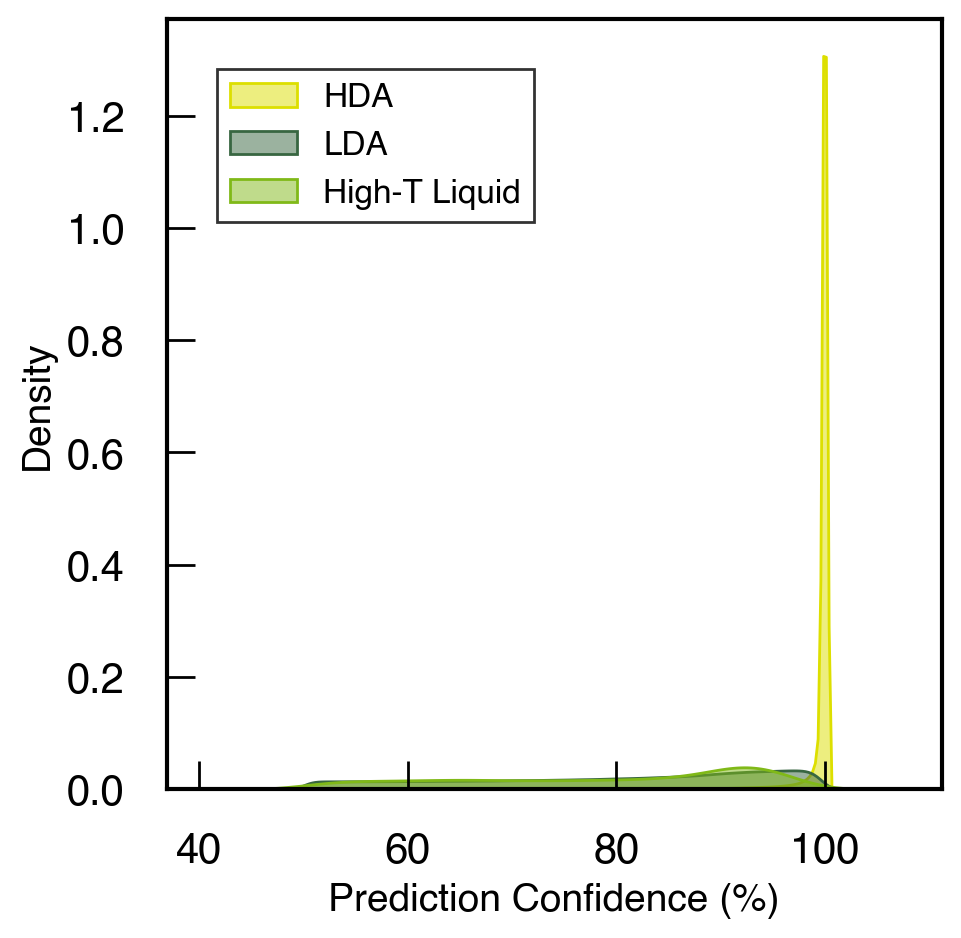

In [15]:
plt.style.use('plot.mplstyle')
fig, ax = plt.subplots(figsize=(5,5))


labels = ['HDA','LDA','High-T Liquid','MDA']
colors = ['#dddf00','#386641','#80b918','#03045e']

for i in range(len(plot_labels)):
    sns.kdeplot(confidences[test_classes==i]*100,label=labels[i],fill=True,ax=ax,color=colors[i],alpha=0.5,linewidth=1)

ax.legend(fontsize=12,loc='upper left')
ax.set_xlabel('Prediction Confidence (%)',fontsize=14);
ax.set_ylabel('Density',fontsize=14);


In [16]:
index_mapping = {}
for key, value in label_mapping.items():
    index_mapping[value] = key

In [25]:
from ase.io import read
from quippy.descriptors import Descriptor
traj_type = 'compression'

temp = 100
run = 1

if traj_type == 'compression':
    pressures =np.arange(100, 20_001, 100)
elif traj_type == 'decompression':
    pressures =np.arange(-5000, 19_901, 100)

traj_proportions = {}
traj_pred_confidences = {} 
traj_pred_classes = {} 
for p in pressures:
    file_name = f"../fausto_water_data/trajectories_{temp}K_run{run}/{traj_type}/{traj_type}_pressure{p}.extxyz"
    structures = read(file_name, index=':')
    # get an average steinhardt descriptor
    descriptors = []
    for s in structures:
        if desc_type == 'soap':
            soap_params = f"soap n_max={n_max} l_max={l_max} cutoff={cutoff} atom_sigma={sigma} average=F n_Z=1 Z=8"
            desc = Descriptor(soap_params)
            descriptors.append(desc.calc(s)["data"])
        else:
            descriptors.append(s.arrays["steinhardt_descriptor"])
    
    # get a single descriptor for the whole trajectory (i.e. the average of all descriptors)
    av_descriptor = np.mean(descriptors, axis=0)

    with torch.no_grad():
        test_x = torch.FloatTensor(scaler.transform(av_descriptor))
        pred_y = torch.nn.Softmax(dim=-1)(neural_net(test_x))

        # get the class with the highest confidence
        pred_class = pred_y.argmax(dim=-1).numpy()
        traj_pred_classes[p] = pred_class
        # get the % confidence for the predicted class
        confidences = pred_y[np.arange(len(pred_y)), pred_class].numpy()
        traj_pred_confidences[p] = confidences
        
        # count the number of 0s, 1s, 2s, and 3s
        class_counts = np.bincount(pred_class, minlength=4)
        traj_proportions[p] = (class_counts / len(pred_class))

In [26]:
class_proportions = {index_mapping[class_num]: [traj_proportions[p][class_num] for p in traj_proportions.keys()] for class_num in range(len(label_mapping))}

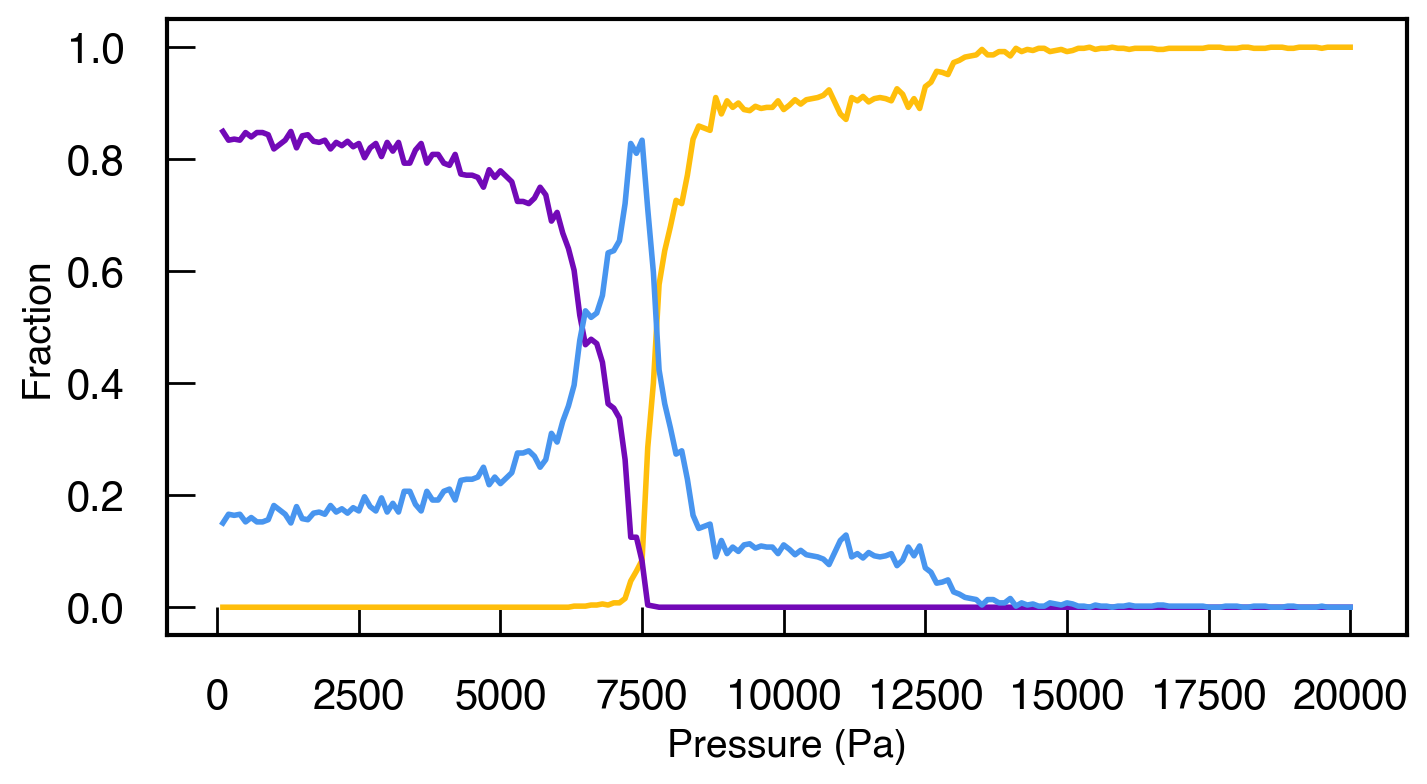

In [27]:
# plot the proportion of each class at each temperature
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('plot.mplstyle')
fig, ax = plt.subplots(figsize=(8,4))

# labels = ['HDA','LDA','Liquid','MDA']
# colors = ['#ffbe0b','#7209b7','#ff006e','#4895ef']
labels = ['HDA','LDA','MDA']
colors = ['#ffbe0b','#7209b7','#4895ef']

for i,(class_name, data) in enumerate(class_proportions.items()):
    ax.plot(traj_proportions.keys(),data,label=labels[i],color=colors[i],linewidth=2)

ax.set_xlabel('Pressure (Pa)',fontsize=14)
ax.set_ylabel('Fraction',fontsize=14)

# plt.gca().invert_xaxis()

# # reverse the order of the legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1],loc='upper left',bbox_to_anchor=(1,0.65))

# ax.set_title(f'Temperature = {temp}K; Run = {run}',fontsize=14);
# plt.savefig(f'../figures/trajectories/{desc_type}_{traj_type}_t{temp}K_run{run}_newColors.svg',dpi=300,bbox_inches='tight')
plt.savefig(f"../figures/paper/{desc_type}_{traj_type}_t{temp}K_run{run}_NoLiquid.svg",dpi=300,bbox_inches='tight')
